# Chapter 5 - Estimating Counts

## The Train Problem
(Originally from _Fifty Challenging Problems in Probability with Solutions_, Frederick Mosteller)
> A railroad numbers its trains from 1 -- N. One day you see a locomotive with the number 60. Estimate the number of locomotives the railway has

Steps:
1. What did we know about N before we saw the data?
2. For each value of $N$, what is the probability of seeing the number 60?

Assume that we don't know anything about the number of trains, so start with a uniform distribution from 1 - 1000

Maximum likelihood: 60


<AxesSubplot:>

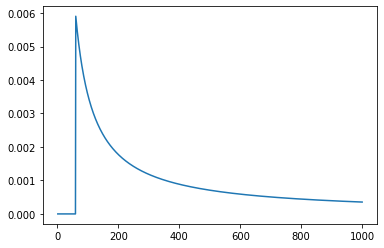

In [1]:
import numpy as np
from empiricaldist import Pmf

hypos = np.arange(1, 1001)
priors = Pmf(1, hypos)

def update_train(pmf: Pmf, data: int):
    """ 
    Update the PMF based on new data
    
    Arguments:
        pmf: the pmf to update
        data (int): the number of a spotted train
    """
    hypos = pmf.qs
    likelihood = 1 / hypos
    impossible = data > hypos
    likelihood[impossible] = 0
    pmf *= likelihood
    pmf.normalize()
    
posterior = priors.copy()
update_train(posterior, 60)

print(f"Maximum likelihood: {posterior.max_prob()}")
posterior.plot()

Maybe this is the wrong approach - although choosing 60 gives us the best chance of being exactly correct, it is ia little squidgy. Maybe we should look at the mean of this distribution. Given the set of quantities $q_i$ and their probabilities $p_i$, $\mu = \sum_i p_i q_i$

In [2]:
# from numpy
from_numpy = np.sum(posterior.qs * posterior.ps)

# built-in Pmf
from_pmf = posterior.mean()

print(f"From numpy: {from_numpy}\nFrom Pmf: {from_pmf}")

From numpy: 333.41989326370776
From Pmf: 333.41989326370776


This appraoch is better if we want to minimize the average error - if you choose this value, you actually minimize the mean-squared error in the guesses.

## Sensitivity to the Prior

It turns out that our estimate is quite sensitive to our upper bound. This is quite concerning, since we really had no strong reason to choose 1000. Behold:

In [3]:
import pandas as pd

upper_bounds = [500, 1000, 2000]
data = pd.DataFrame(index=upper_bounds)
means = []
for upper_bound in [500, 1000, 2000]:
    hypos = np.arange(1, upper_bound + 1)
    priors = Pmf(1, hypos)
    posterior = priors.copy()
    update_train(posterior, 60)
    means.append(posterior.mean())
    
data["Posterior Means"] = means
data

,Posterior Means
500,207.079228
1000,333.419893
2000,552.179017


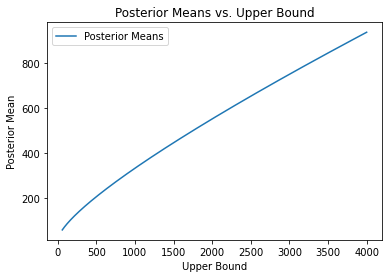

In [4]:
import matplotlib.pyplot as plt

xs = range(60, 4000)
ys = []
for upper_bound in xs:
    hypos = np.arange(1, upper_bound + 1)
    priors = Pmf(1, hypos)
    posterior = priors.copy()
    update_train(posterior, 60)
    ys.append(posterior.mean())
    
fig, ax = plt.subplots()
ax.set_xlabel("Upper Bound")
ax.set_ylabel("Posterior Mean")
ax.set_title("Posterior Means vs. Upper Bound")
ax.plot(xs, ys, label="Posterior Means")
ax.legend()

So you can see that there is a *strong* dependence on our upper bound, which isn't great!

## Power Law Prior

If we can't get more data, we can do some research and improve our priors. It is probably not too likely that a company can have 1 or 1000 trains, but that is what we assumed.

From some research, we learn that companies tend to follow a Power Law distribution: many small ones, some medium ones, few large ones. More formally
$$
\# \text{companies of size N} \, \propto\, \left( \frac{1}{N} \right)^\alpha
$$
where $\alpha$ is generally near 1.

We can construct a Power Law prior as follows:

<AxesSubplot:>

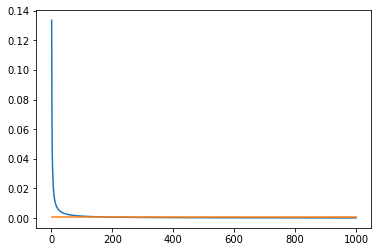

In [5]:
hypos = np.arange(1, 1001)
alpha = 1.0
ps = hypos ** (-1 * alpha)
power = Pmf(ps, hypos, name="power")
power.normalize()

# and the uniform again
uniform = Pmf(1, hypos, name='uniform')
uniform.normalize()

power.plot()
uniform.plot()

<AxesSubplot:>

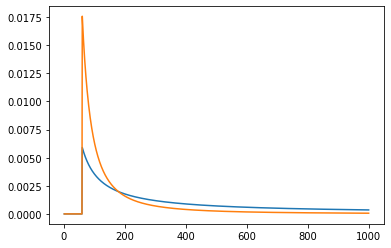

In [6]:
dataset = [60]
update_train(uniform, dataset)
update_train(power, dataset)
uniform.plot()
power.plot()

The power law prior results in less emphasis on the higher values, hopefully leading to less dependence on the upper bounds. In fact, we can take a look now:

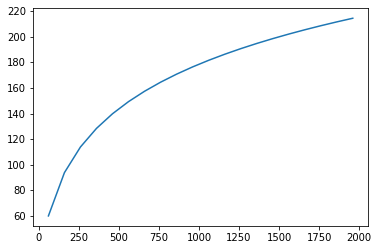

In [7]:
xs = range(60, 2000, 100)
ys = []
for upper_bound in xs:
    hypos = np.arange(1, upper_bound + 1)
    power_prior_probs = hypos ** -1.0
    power_posteriors = Pmf(power_prior_probs, hypos)
    update_train(power_posteriors, 60)
    ys.append(power_posteriors.mean())
    
fig, ax = plt.subplots()
ax.plot(xs, ys)
    

So we can see that there is much less of a dependence. With more data (more trains), the dependence lessens.

## Credible Intervals

So far we have two ways to determine the number of trains:
1. Number with highest probability
2. Mean of posterior distribution

These are both point estimates. We can also summarize using percentiles.

Recall: xth percentile is the lowest score (or whatever) such that >= x% of the data lies below it. 

*Percentile rank*: The sum of probabilities for values <= x

In [8]:
# percentile rank for power
power.prob_le(100)

0.43374679026783564

We can also define a function to calculate this for us

In [9]:
def quantile(pmf, prob):
    """ Compute a quantile (difference is quantile: 0-1; percentile: 1-100) with the given probability """
    total = 0
    for q, p in pmf.items():
        total += p
        if total >= prob:
            return q
    return np.nan

quantile(power, 0.5)

112

So this is the median of the distribution.

`Pmf` also has a built-in function `quantile` that does the same thing.

In [10]:
power.quantile(0.5)

array(112.)

In [11]:
power.quantile([0.05, 0.95])

array([ 62., 559.])

This tells us that there is a 5% chance that the number of trains is less than or equal to 62, and a 5% chance that it is greater than 559.

We call the interval (62, 559] the *90% credible interval* - there is a 90% chance that the number of trains falls in this range!

(
`Pmf` also has a `credible_interval(percent)` function:
)

In [12]:
power.credible_interval(0.9)

array([ 62., 559.])

## Informative and Uninformative Priors

- Informative: include as much information as we know. This runs the risk of our information being wrong or unduly influencing the final result
- Uninformative prior: include as little information as possible to 'allow the data to speak for itself'

## Exercises

## 5.1
> You are giving a lecture in a large hall. Fire Marshal thinks that there are more than 1200 people. It would take too long to count, so you run an experiment:
> - How many people born May 11: 2
> - How many people born May 23: 1
> - How many people born August 1: 0
> How many people are there in the audience? What is the probability that there are more than 1200 people?

### Solution

Let's say that we can determine the number of people $\pm 400$ with a fair degree of accuracy - that is, if there were 800 or less we would know, and if there were more than 1600 we would know as well. For simplicity, we'll also ignore leap years.

Mean value: 486.22786415246316


<AxesSubplot:>

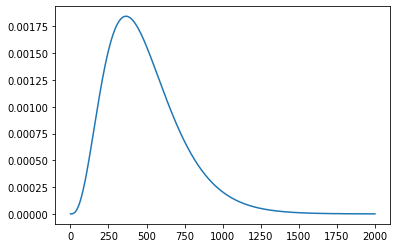

In [13]:
from scipy.stats import binom

hypos = np.arange(1, 2000)
priors = Pmf(1, hypos)
priors.normalize()

posteriors = priors.copy()
may_11_probs = binom.pmf(2, hypos, 1/365)
may_23_probs = binom.pmf(1, hypos, 1/365)
august_1_probs = binom.pmf(0, hypos, 1/365)

posteriors *= (may_11_probs * may_23_probs * august_1_probs)
posteriors.normalize()
print(f"Mean value: {posteriors.mean()}")
posteriors.plot()

In [14]:
prob_ge_1200 = posteriors.prob_ge(1200)
print(f"Probability that there are more than 1200: {prob_ge_1200}")

Probability that there are more than 1200: 0.011305102026983009


## 5.2 
> I often see rabbits behind my house. Suppose there is a camera that takes a picture of the first rabbit it sees each day. After three days, I take look at the pictures and conclude that two are the same and one is different. How many rabbits visit my garden?
>
> Think about the priors:
> - I have sometimes seen 4 rabbits at the same time, so there are more than that
> - I would be surprised if there were more than 10 -> probably a uniform of 4 -- 10 would be a reasonable prior
> - Assume that all rabbits are equally likely to be caught by the camera trap and that the camera takes a picture every day

### Solution

We have three days worth of data. If there are $n$ rabbits, then we get the first day for free, but then we have one different and one same. $P(d|n) = \frac{1}{n} \ast \frac{n - 1}{n}$ (we see the same rabbit: 1/n, and a different one: (n - 1) / n)

Mean value: 6.50992981374817


<AxesSubplot:>

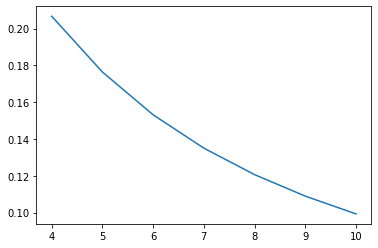

In [15]:
hypos = np.arange(4, 10 + 1)
priors = Pmf(1, hypos)
priors.normalize()

likelihood_probs = (hypos - 1) / (hypos ** 2)
likelihood = Pmf(likelihood_probs, hypos)
likelihood.normalize()

posteriors = priors.copy()
posteriors *= likelihood
posteriors.normalize()

print(f"Mean value: {posteriors.mean()}")
posteriors.plot()

## 5.3 
> Suppose in the criminal justice system, all sentences are either 1, 2, or 3 years, with an equal number of each. One day, you visit a prison and choose a prisoner at random. What is the probability that they are serving a 3-year sentence? What is the average remaining sentence of the prisoners you observe?

### Solution

Say that in each year, $n$ people are sentenced to be in prison. n/3 are one year sentences, n/3 are two year, and n / 3 are three year. Then in year $k$, there are $n + 2 n / 3 + n / 3 = 2n$ people serving. 
$$
\begin{align}
P(3 year) &= (n / 3 + n / 3 + n / 3) / 2n = 1/2 \\
P(2 year) &= (n / 3 + n / 3) / 2n = 1/3 \\
P(1 year) &= (n / 3) / 2n = 1/6
\end{align}
$$

The average remaining sentence is
$$
\begin{align}
\mu &= (1/6 * 1 + 1/3 * 2 + 1/2 * 3) / 2 \\
    &= 7 / 6 
\end{align}
$$

We divide by two because we are calculating the total sentence, and on average they are halfway through their sentences.

In [16]:
# Alternate solution:
hypos = [1, 2, 3]
priors = Pmf(1/3, hypos) # they are equally likely
priors

,probs
1,0.333333
2,0.333333
3,0.333333


,probs
1,0.166667
2,0.333333
3,0.500000


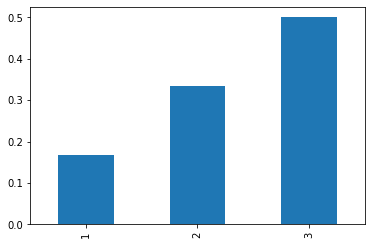

In [17]:
# if you visit, the likelihood of seeing someone with a sentence of a given length is proportional to the sentence:
# they "survive" that long.

likelihood = hypos

posterior = priors * likelihood
posterior.normalize()
posterior.plot(kind="bar")
posterior

## 5.4 
> If I chose a random adult in the US, what is the probability that they have a sibling? To be precise, what is the probability that their mother has had at least one other child? Addition information from [here](https://www.pewresearch.org/social-trends/2015/05/07/family-size-among-mothers/) may be helpful.

### Solution

Relevant information:
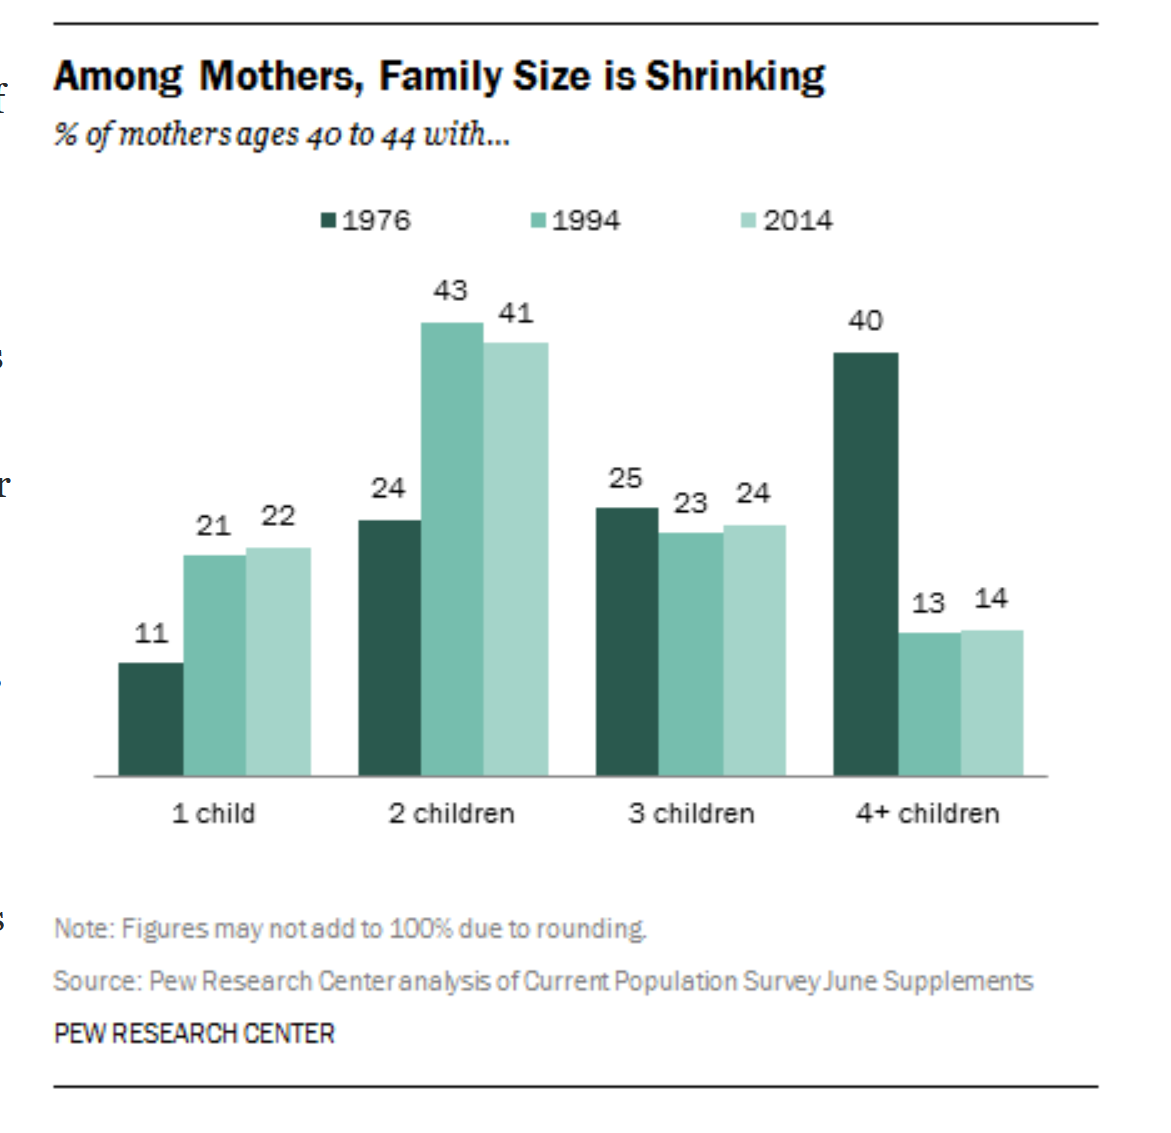

Let's also simplify this by saying that 4+ = 4.

Also remember: we don't care about the number of siblings, just whether or not they had a sibling -> 

1 child (no siblings): 22%
2 child (sibling): 41%
3 children (sibling): 24%
4 children (sibling): 14%

Say we have $n$ mothers. Then we have 0.11n + 2 * 0.41n + 3 * 0.24n + 4 * 0.14n = 2.32n children.

Choose one at random: the probability that they have no sibling is 0.22n / 2.32n = 


In [18]:
total_population = 0.22 + 2 * 0.41 + 3 * 0.24 + 4 * 0.14
prob_no_siblings = 0.22 / total_population
print(f"Total population: {total_population}n")
print(f"Probability of no siblings: {prob_no_siblings}")
print(f"Probbility of having siblings: {1 - prob_no_siblings}")

Total population: 2.3200000000000003n
Probability of no siblings: 0.09482758620689655
Probbility of having siblings: 0.9051724137931034


In [19]:
# Alternative solution using statistics

qs = [1, 2, 3, 4]
ps = [0.22, 0.41, 0.24, 0.14]
prior = Pmf(ps, qs)
prior.normalize()

# The likelihood of a random person being part of a group of $n$ children is proportional to $n$:
likelihood = Pmf(qs, qs)
likelihood.normalize()

posterior = prior * likelihood
posterior.normalize()

1 - posterior[1]

0.9051724137931034

## 5.5
> The Doomsday argument is a probabilistic argument that claims to predict the number of future members of the human species given an estimate of the total number of humans born so far.
>
> Suppose that there are only two kinds of intelligent civilization.
> - Short lived: go extinct after 200 billion individuals
> - Long lived: go extinct after 2000 billion individuals
> Suppose that the different types are equally likely. Which kind of civilization do you think we live in?
>
> The Doomsday argument says that we can use the total number of humans born. According to the Population Reference Bureau, the total number of humans that have lived is about 108 billion. Assume that you are human number 108 billion exactly. If N is the total number of people who will ever live, it is equally likely that you would be human 1, N, or anywhere in between. So, what is the probability that you would be human 108 billion?
>
> Given this data and dubious prior, what is the probability that our civilization will be short-lived?

### Solution

,probs
2.000000e+11,0.909091
2.000000e+12,0.090909


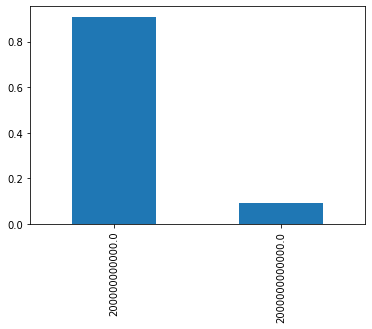

In [20]:
hypos = [200 * 1e9, 2000 * 1e9]
prior = Pmf(1, hypos)
prior.normalize()

likelihood = list(map(lambda x: 1 / x, hypos))

posterior = prior * likelihood
posterior.normalize()
posterior.plot(kind="bar")

posterior